In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft,irfft
from matplotlib.colors import LogNorm
from itertools import combinations
import sys, os

parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
import telescope_1d

In [2]:
# Initialize telescope
telescope = telescope_1d.Telescope1D(Nfreq=256, Ndishes=32, DDish=6, Npix=2**12, Npad=2**8,
                                     minfreq=400, maxfreq=800, redundant=False)

Get beam sensitivity for baseline length 6 meters, frequency 800 MHz:

Text(0, 0.5, 'Power')

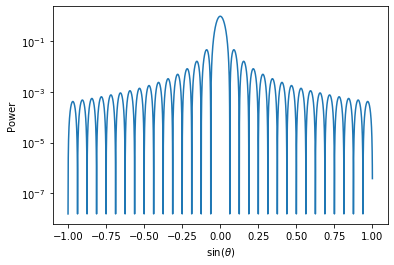

In [3]:
pbeam = telescope.primary_beam_1(800)**2 
plt.plot(telescope.alpha,pbeam/pbeam.max())
plt.semilogy()
plt.xlabel(r'sin($\theta$)')
plt.ylabel('Power')

Let's find a response to a point source.

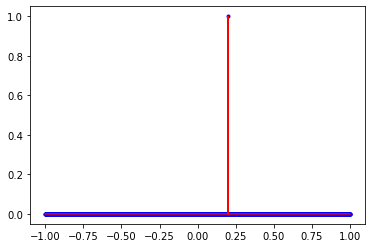

In [4]:
image = telescope.empty_image()
# Choose an index for the point source from 0 to Npix-1
ndx = int(telescope.Npix*60/100)
image[ndx] = 1
plt.plot(telescope.alpha,image,'b.')
plt.plot(telescope.alpha,telescope.uv2image(telescope.image2uv(image)),'r-')

Ignore beam for now. Transform image to uv space, then pick out the indices we want and construct uvplane.

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'visibility')

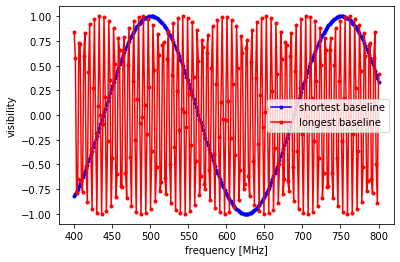

In [5]:
uv = telescope.image2uv(image)
uvplane = telescope.uv2uvplane(uv, indices=None)
plt.plot(telescope.freqs,uvplane[:,0],'b.-', label='shortest baseline')
plt.plot(telescope.freqs,uvplane[:,-1],'r.-', label='longest baseline')
plt.legend()
plt.xlabel('frequency [MHz]')
plt.ylabel('visibility')

Compare with visibility from analytical approach (for shortest baseline).

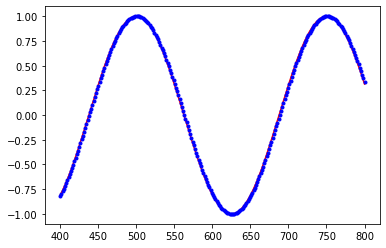

In [6]:
al = telescope.alpha[ndx]
direct = np.cos(telescope.DDish/telescope.lams*2*np.pi*al)
plt.plot(telescope.freqs,direct,'r-')
plt.plot(telescope.freqs,uvplane[:,0],'b.')

We can now see the interpolation errors; the scheme is percent accurate.

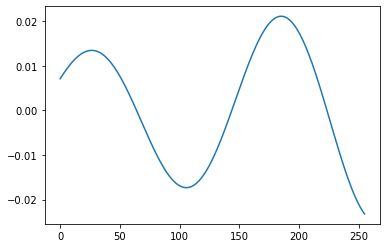

In [7]:
plt.plot(direct-np.real(uvplane[:,0]))

Let's image this back. Try with and without error (use time delay error of sigma 10 picoseconds).

In [8]:
rmap_no_error = telescope.get_obs_rmap(uvplane, time_error_sigma=0)
rmap_with_error = telescope.get_obs_rmap(uvplane, time_error_sigma=10e-12)

Plot the synthesized beams. Choose range of angles close to where the point source is.

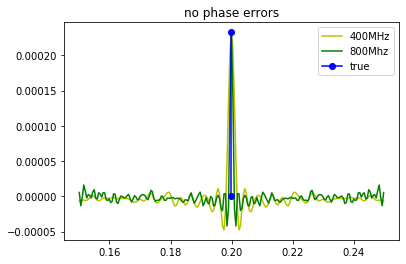

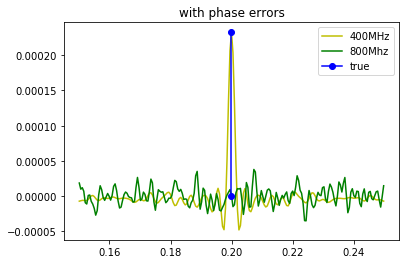

In [9]:
wal = np.where((telescope.alpha>al-0.05) & (telescope.alpha<al+0.05))

plt.plot(telescope.alpha[wal],rmap_no_error[0,wal[0]],'y-',label='400MHz')
plt.plot(telescope.alpha[wal],rmap_no_error[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_no_error.max()],'bo-',label='true')
plt.title('no phase errors')
plt.legend()
plt.show()

plt.plot(telescope.alpha[wal],rmap_with_error[0,wal[0]],'y-',label='400MHz')
plt.plot(telescope.alpha[wal],rmap_with_error[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_with_error.max()],'bo-',label='true')
plt.title('with phase errors')
plt.legend()
plt.show()

Plot the rmap for the two cases. The lines from redundant baselines are faded and more sparse with less redundant baseline lengths. With significantly large phase errors, the lines go away, because phase errors shift each line, and since phase errors are chosen randomly, when averaging over all the baselines, the redundancy goes away. Phase errors are larger for larger frequencies.

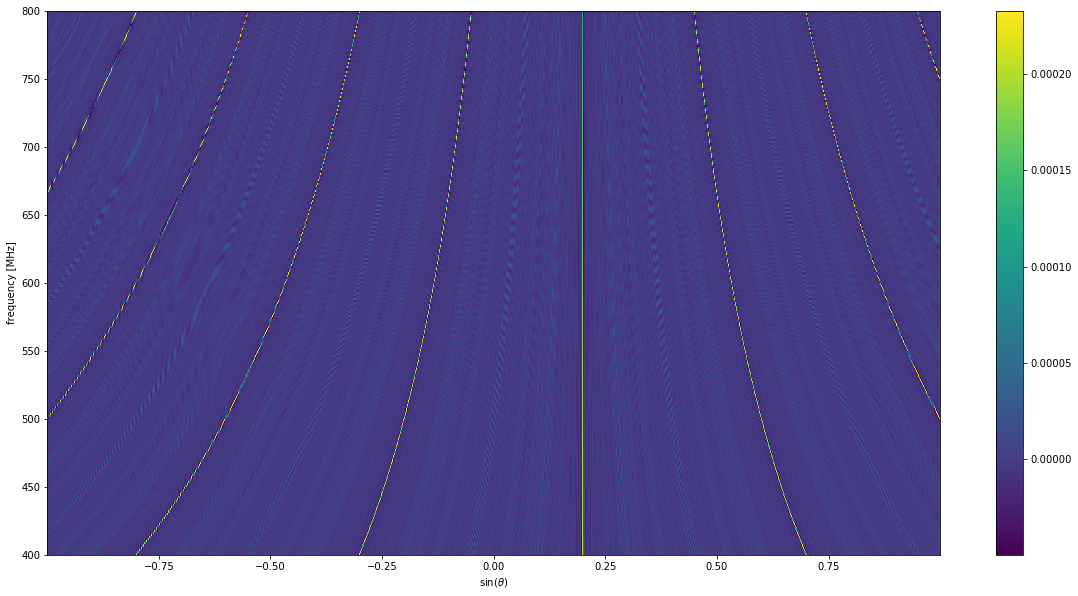

In [10]:
telescope.plot_rmap(rmap_no_error)

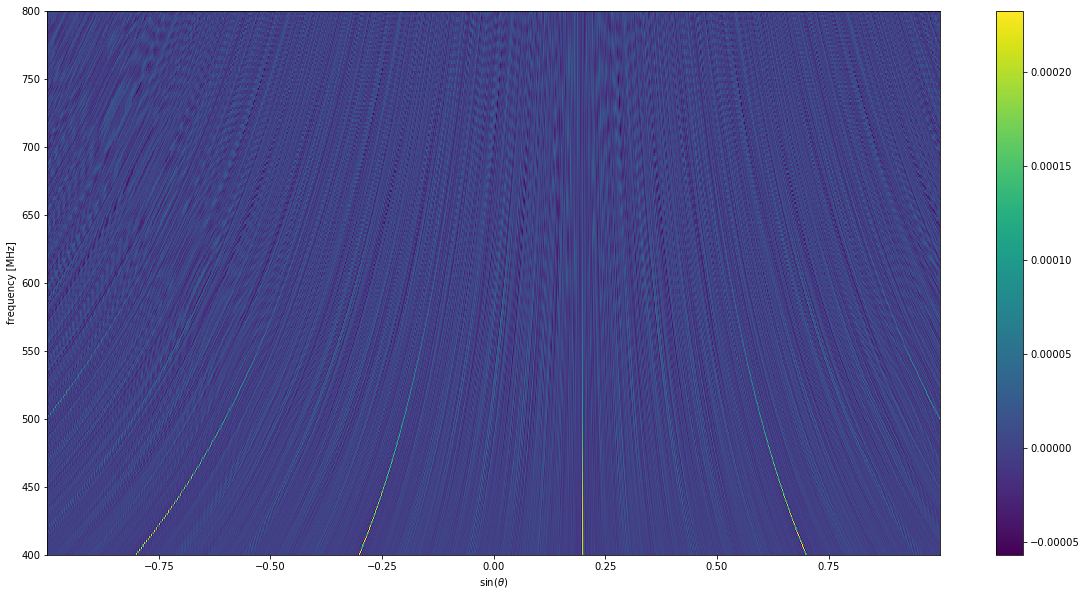

In [11]:
telescope.plot_rmap(rmap_with_error)

Plot the difference between rmap with and without phase errors (normalized).

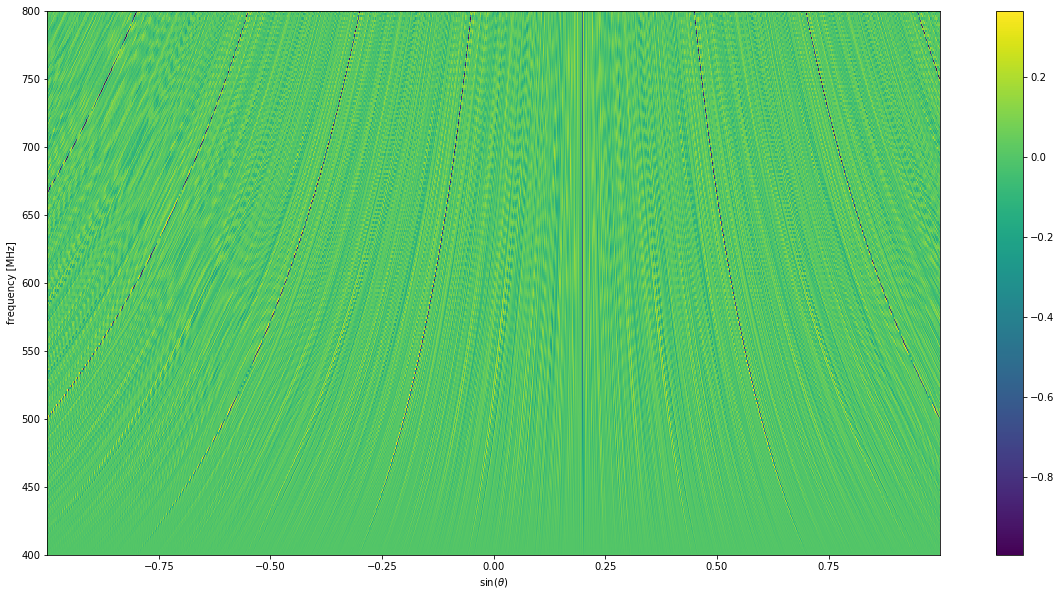

In [12]:
telescope.plot_rmap(rmap_with_error/rmap_no_error.max() - rmap_no_error/rmap_no_error.max())

Now let's plot some wedge.

/usr/lib/python3/dist-packages/numpy/fft/_pocketfft.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


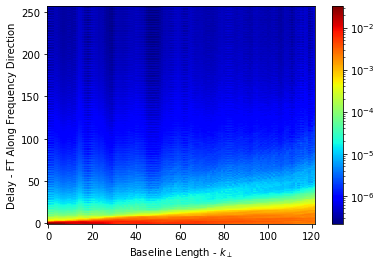

In [13]:
telescope.plot_wedge(Nreal=100)